A minimal example of gradient ascent. Search for TODO to see what code you can attempt to add.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import tensorflow as tf

from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

A few utilities for reading and preprocessing images.

73728/64992 [==================================] - 0s 1us/step


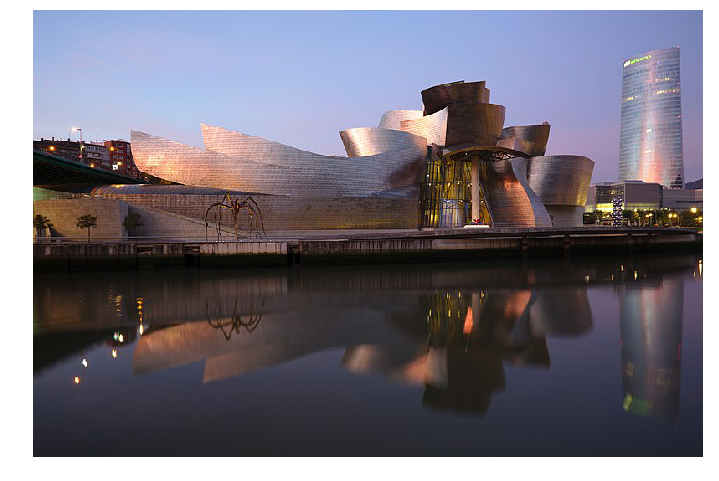

In [3]:
# Download an image and read it into a NumPy array, 
def download(url):
  name = url.split("/")[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = image.load_img(image_path)
  return image.img_to_array(img)

# Scale pixels to between (-1.0 and 1.0)
def preprocess(img):
  return (img / 127.5) - 1
  
# Undo the preprocessing above
def deprocess(img):
  img = img.copy()
  img /= 2.
  img += 0.5
  img *= 255.
  return np.clip(img, 0, 255).astype('uint8')

# Display an image
def show(img):
  plt.figure(figsize=(12,12))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Bilbao_-_Guggenheim_aurore.jpg/800px-Bilbao_-_Guggenheim_aurore.jpg'
img = preprocess(download(url))
show(deprocess(img))

Build a feature extraction model using the [Keras Functional API](https://www.tensorflow.org/alpha/guide/keras/functional). It's pretty sweet!

In [4]:
inception_v3 = tf.keras.applications.InceptionV3(weights='imagenet',
                                                 include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [0]:
# We'll maximize the activations of these layers
names = ['mixed2', 'mixed3', 'mixed4', 'mixed5']
layers = [inception_v3.get_layer(name).output for name in names]

# Create our feature extraction model
feat_extraction_model = tf.keras.Model(inputs=inception_v3.input, outputs=layers)

Here's our forward pass.

In [0]:
def forward(img):
  
  # Create a batch
  img_batch = tf.expand_dims(img, axis=0)
  
  # Forward the image through Inception, extract activations
  # for the layers we selected above
  return feat_extraction_model(img_batch)

That's it for feature extraction. Now let's define our loss function. It'll be the mean activation of each of the layers we chose above.

In [0]:
def calc_loss(layer_activations):
  
  total_loss = 0
  
  for act in layer_activations:
    
    # In gradient ascent, we'll want to maximize this value
    # so our image increasingly "excites" the layer
    
    ##############
    # TODO
    # set the loss equal to the mean activation at this layer
    # loss = ...
    ########################
    loss = tf.math.reduce_mean(act)

    # Normalize by the number of units in the layer
    loss /= np.prod(act.shape)
    total_loss += loss

  return total_loss

We can now run gradient ascent (this is similar to training a classifier, with a twist). We'll treat our input image as a weight matrix, and find the gradients of the loss with respect to it. Those gradients will have the same shape as the image (since there's one for each pixel) - so we can add them directly to the image to modify it. Rinse and repeat.

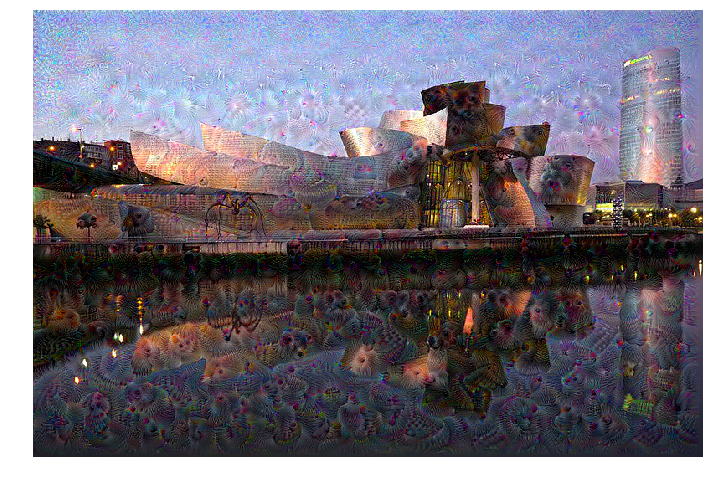

In [8]:
# Convert our image into a variable for training
img = tf.Variable(img)

# Run a few iterations of gradient ascent
steps = 400

for step in range(steps):
  
  with tf.GradientTape() as tape:    
    activations = forward(img)
    loss = calc_loss(activations)
    
  # How cool is this? It's the gradient of the 
  # loss (how excited the layer is) with respect to the
  # pixels of our random image!
  
  ##############
  ## TODO: your code here
  ## Calculate the gradients of the loss w.r.t. the image
  ## See: http://bit.ly/tf-ws1
  ## gradients = tape.gradient ...
  ##############
  gradients = tape.gradient(loss, img)

  # Normalize the gradients
  gradients /= gradients.numpy().std() + 1e-8 
  
  # Update our image by directly adding the gradients
  # (because they're the same shape!)
  
  ##############
  # TODO
  # Add the gradients to the variable
  # Normally, you do not need to write code at this low of a level
  # See https://www.tensorflow.org/beta/guide/variables
  # img.assign...(gradients)
  ##############
  img.assign_add(gradients)
  
  if step % 50 == 0:
    clear_output()
    print ("Step %d, loss %f" % (step, loss))
    show(deprocess(img.numpy()))
    plt.show()

# Let's see the result
# Notice we're calling .numpy() here, which 
# takes us from TensorFlow land -> NumPy land
clear_output()
show(deprocess(img.numpy()))

That's it! For the bells and whistles (there are many) you can explore this full [implementation](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/deepdream) in TensorFlow v1 (perfect for concepts, but you'll probably want to adapt the code to something more modern), and this helpful [notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.2-deep-dream.ipynb) from Deep Learning with Python using the Keras reference implementation.

*Update*: we added a faster implementation in TF 2.0 here: https://www.tensorflow.org/beta/tutorials/generative/deepdream